In [1]:
import sqlite3
import pandas as pd
import numpy as np

# **Getting Stock Data for Tickers for Analysis**

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.head(10)
# df.to_csv('S&P500-Info.csv')
# df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008
6,ADM,ADM,Consumer Staples,Agricultural Products,"Chicago, Illinois",1957-03-04,7084,1902
7,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
8,ADP,ADP,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949
9,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932


In [3]:
sp_tickers = list(df.Symbol.unique())
len(sp_tickers)

503

In [4]:
db = sqlite3.connect('stock_data.db')
cur = db.cursor()

In [5]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'JPM', 'SPY']

where_clause = '('

for i, ticker in enumerate(sp_tickers):
    if i < len(sp_tickers) - 1:
        where_clause += f"'{ticker}'" + ', '
    else:
        where_clause += f"'{ticker}'" + ')'


In [6]:
prices_sql = f'''
    SELECT *
    FROM stock_etf_prices
    WHERE ticker IN {where_clause}
'''

In [7]:
prices_df = pd.read_sql_query(prices_sql, db).drop(['index'], axis = 1)

In [8]:
prices_df.head()

,ticker,is_stock,date,open,high,low,close,adj_close,volume
0,CSCO,1,1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800.0
1,CSCO,1,1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400.0
2,CSCO,1,1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200.0
3,CSCO,1,1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000.0
4,CSCO,1,1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600.0


In [9]:
prices_df['ticker'].value_counts()

CAT     14665
MO      14664
KO      14664
XOM     14663
GE      14663
        ...  
MRNA      331
FOXA      268
FOX       267
DOW       262
CTVA      216
Name: ticker, Length: 485, dtype: int64

In [10]:
prices_df.date = pd.to_datetime(prices_df.date)
prices_df.dtypes

ticker               object
is_stock              int64
date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume              float64
dtype: object

In [11]:
agg_dict = {
    'date': ['min', 'max'],
    'adj_close': ['min', 'max'],
    'volume': ['min', 'max']
}
prices_df[['ticker', 'date', 'adj_close', 'volume']].groupby(by = 'ticker').agg(agg_dict)

date             adj_close                 volume              
              min        max        min         max        min           max
ticker                                                                      
A      1999-11-18 2020-04-01   6.674886   97.816307   271900.0  6.254630e+07
AAL    2005-09-27 2020-04-01   1.659225   59.345577   138500.0  1.377672e+08
AAP    2001-11-29 2020-04-01  11.882058  198.368835     9000.0  1.974950e+07
AAPL   1980-12-12 2020-04-01   0.155638  327.200012   347200.0  1.855410e+09
ABBV   2013-01-02 2020-04-01  25.014784  109.919968  1612800.0  1.227402e+08
...           ...        ...        ...         ...        ...           ...
YUM    1997-09-17 2020-04-01   2.802153  118.169907   420600.0  5.110630e+07
ZBH    2001-07-25 2020-04-01  23.263008  160.002426   233400.0  1.280240e+07
ZBRA   1991-08-15 2020-04-01   3.277778  259.140015     1300.0  1.786320e+07
ZION   1980-03-17 2020-04-01   0.465946   75.023361        0.0  2.633310e+07
ZTS    2013-02-01 2020-04-01  27.137039  144.940002   438700.0  6.678910e+07

[485 rows x 6 columns]

In [10]:
# prices_df.set_index(['ticker', 'date'], inplace = True).drop(['open', 'high', 'low', 'close', 'is_stock'], axis = 1, inplace = True)
# prices_df.drop(['open', 'high', 'low', 'close', 'is_stock'], axis = 1, inplace = True)
# prices_df

In [12]:
temp_df = prices_df.loc[prices_df.date.dt.year >= 2018]
temp_df.ticker.value_counts()

BMY     567
GL      567
NEM     567
CAH     567
AXP     567
       ... 
TT      318
FOXA    268
FOX     267
DOW     262
CTVA    216
Name: ticker, Length: 485, dtype: int64

## Creating the Technical Indicators for Stock

SMA, EMA, Bollinger Bands, MACD, RSI

In [13]:
from technical_indicators import *

df1 = calc_sma(prices_df)
df2 = calc_ema(df1)
df3 = calc_bollinger_bands(df2)
df4 = calc_macd(df3)
df5 = calc_rsi(df4)

final_df = df5.drop(['is_stock', 'open', 'high', 'low', 'close'], axis = 1)
final_df = final_df.loc[final_df.date.dt.year >= 2005].reset_index(drop = True)
final_df

,ticker,date,adj_close,volume,sma_50,sma_200,ema_12,ema_16,ema_50,ema_200,bb_upper_20,bb_lower_20,ema_26,macd,rsi
0,CSCO,2005-01-03,14.955894,56725600.0,14.883281,16.053935,14.958982,14.956625,14.930465,15.627890,15.325096,14.681131,14.942912,0.016070,49.802327
1,CSCO,2005-01-04,14.367563,106241900.0,14.887771,16.038685,14.867995,14.887324,14.908391,15.615350,15.347259,14.561430,14.900294,-0.032299,23.786307
2,CSCO,2005-01-05,14.375301,66100500.0,14.895667,16.024055,14.792196,14.827086,14.887485,15.603011,15.351110,14.467781,14.861406,-0.069210,24.385762
3,CSCO,2005-01-06,14.592060,63790900.0,14.907124,16.010469,14.761406,14.799436,14.875900,15.592952,15.289562,14.455789,14.841454,-0.080049,39.712234
4,CSCO,2005-01-07,14.491426,54415000.0,14.909756,15.995180,14.719870,14.763199,14.860823,15.581991,15.290251,14.402460,14.815526,-0.095656,35.822556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719578,PPL,2020-03-26,24.670000,8470200.0,31.729091,31.282706,23.874731,24.878530,29.655917,31.204652,35.025612,17.774481,26.953136,-3.078405,51.281923
1719579,PPL,2020-03-27,25.420000,6977500.0,31.529935,31.260007,24.112465,24.942232,29.489803,31.147094,34.689821,17.690796,26.839570,-2.727105,54.344895
1719580,PPL,2020-03-30,25.830000,6449900.0,31.336807,31.239598,24.376701,25.046676,29.346281,31.094187,34.051621,17.772891,26.764787,-2.388086,56.086390
1719581,PPL,2020-03-31,24.680000,5682900.0,31.118113,31.211804,24.423362,25.003537,29.163290,31.030364,33.457404,17.771989,26.610359,-2.186996,49.923304


In [16]:
import matplotlib.pyplot as plt

In [ ]:
def plot_indicators(df):
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    df

<AxesSubplot:xlabel='date'>

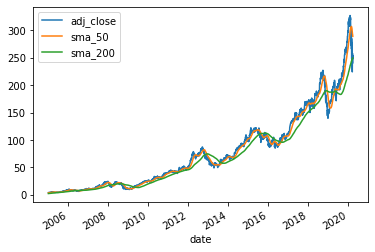

In [17]:
aapl_df = final_df.loc[final_df.ticker == 'AAPL']
aapl_df[['date', 'adj_close', 'sma_50', 'sma_200']].set_index('date').plot()